In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandasql as ps
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()

## 1. Data Quality Check

In [2]:
train=pd.read_csv('D:/WorkSample/DrugStoreSales/train.csv')
test=pd.read_csv('D:/WorkSample/DrugStoreSales/test.csv')
store=pd.read_csv('D:/WorkSample/DrugStoreSales/store.csv')

C:\Users\yanli\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



In [3]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Since the task is predicting the sales, so sales data that are zero are irrelevant. To make sure model is built better, we need to remove those data.

In [6]:
train['Open'].value_counts()

1    844392
0    172817
Name: Open, dtype: int64

We can see that in the training dataset there are 172817 rows with 0 sales.

In [7]:
train = train[train['Sales']>0]
train['Open'].value_counts()

1    844338
Name: Open, dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Store          844338 non-null  int64 
 1   DayOfWeek      844338 non-null  int64 
 2   Date           844338 non-null  object
 3   Sales          844338 non-null  int64 
 4   Customers      844338 non-null  int64 
 5   Open           844338 non-null  int64 
 6   Promo          844338 non-null  int64 
 7   StateHoliday   844338 non-null  object
 8   SchoolHoliday  844338 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 64.4+ MB


We can see that the 'Date' column contains datatype of object. We need to convert it into datetime and sort it properly.

In [9]:
train['Date']=pd.to_datetime(train['Date'])
train.sort_values(by='Date',ascending=True,inplace=True)
train.reset_index(inplace=True)
train.drop('index',axis=1,inplace=True)

start_date = train['Date'][0]
end_date = train['Date'][844337]
print(f'Start date is {start_date}')
print(f'End date is {end_date}')

Start date is 2013-01-01 00:00:00
End date is 2015-07-31 00:00:00


In [10]:
print( 'DayOfWeek'+':',train['DayOfWeek'].unique())
print( 'Open'+':',train['Open'].unique())
print( 'Promo'+':',train['Promo'].unique())
print( 'StateHoliday'+':',train['StateHoliday'].unique())
print( 'SchoolHoliday'+':',train['SchoolHoliday'].unique())

DayOfWeek: [2 3 4 5 6 7 1]
Open: [1]
Promo: [0 1]
StateHoliday: ['a' '0' 'b' 'c' 0]
SchoolHoliday: [1 0]


We can see that Column 'Open' has only one value, so we can drop it since it has no help to us. For the 'StateHoliday', we need to drop those two '0's.

In [11]:
index=train[train['StateHoliday']==0].index
train['StateHoliday'][index]='0'
train['StateHoliday'].value_counts()
train.drop('Open',axis=1,inplace=True)

## 2. Data Visualization and Analysis

#### 2.1 Sales on different days of week

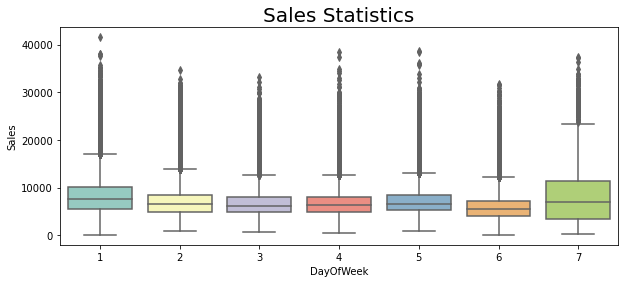

In [22]:
plt.figure(figsize=(10,4))
sns.boxplot(y='Sales',x='DayOfWeek',data=train,palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()

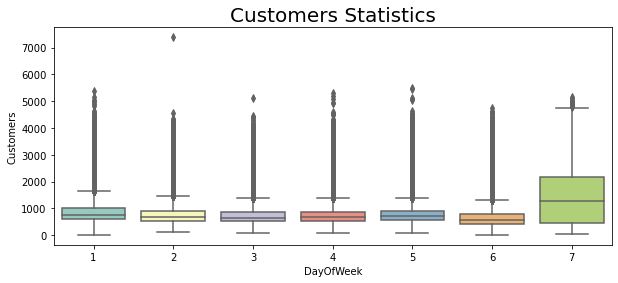

In [23]:
plt.figure(figsize=(10,4))
sns.boxplot(y='Customers',x='DayOfWeek',data=train,palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

From boxplots of sales and customers on different days of week, we can see that people shop and spend more on Sunday. 

#### 2.2 Sales and number of customers with promo

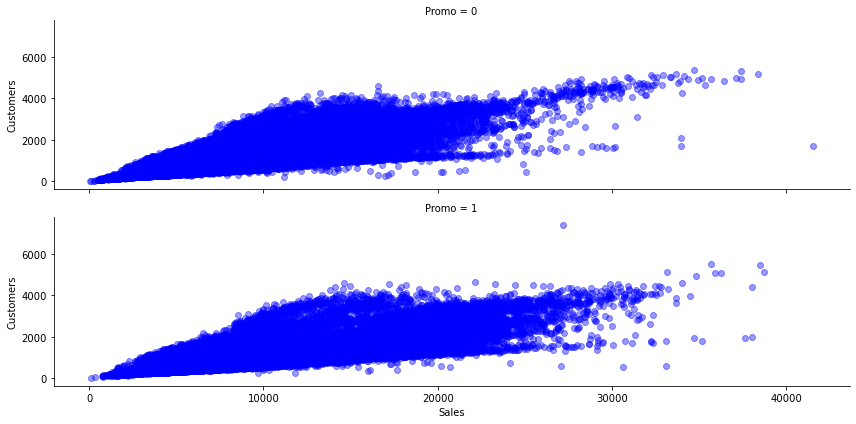

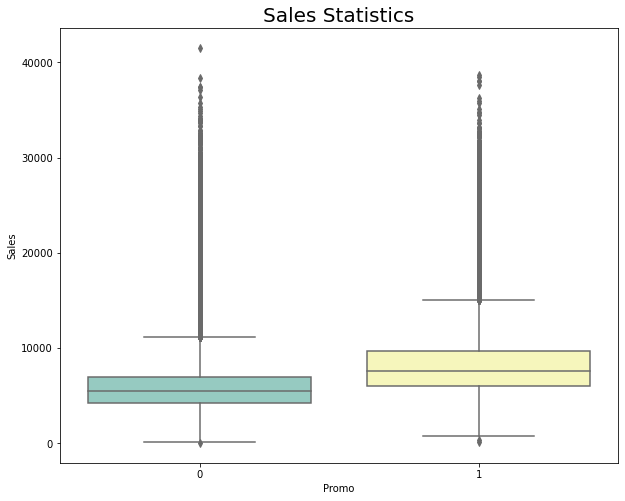

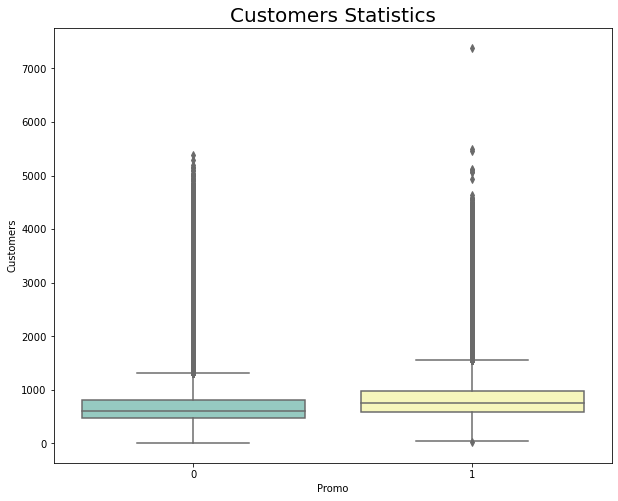

In [24]:
g=sns.FacetGrid(row='Promo',data=train,height=3,aspect=4)
g.map(plt.scatter,'Sales','Customers',color='blue',alpha=0.4)
plt.show()

plt.figure(figsize=(10,8))
sns.boxplot(y='Sales',x='Promo',data=train,palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()

plt.figure(figsize=(10,8))
sns.boxplot(y='Customers',x='Promo',data=train,palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

From scatter plots and box plots above we can see that running promo will not have huge effect on number of customers. However, It can stimulate the sales. The reason, I assume, is that people tends to pay for anything that is on discount, even though they don't really need it. 

#### 2.3 Sales and customers with state holidays

a = public holiday, b = Easter holiday, c = Christmas, 0 = None

Scatter plot is not useful in this section since the sample size is imbalanced. To be more sepcific, number of public holiday and none holiday is way bigger than the number of easter holiday and christmas. 

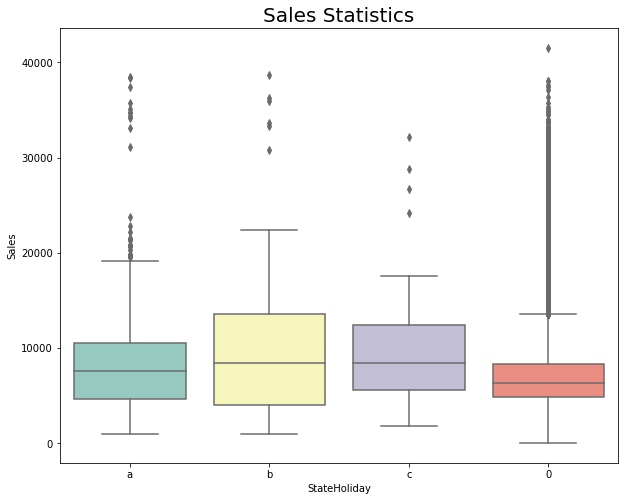

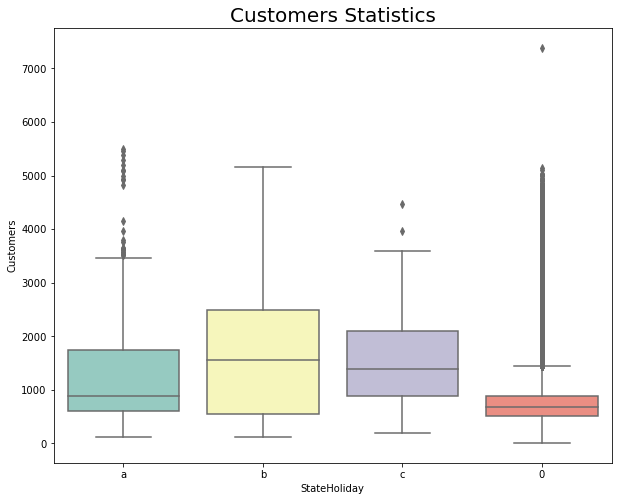

In [25]:
plt.figure(figsize=(10,8))
sns.boxplot(y='Sales',x='StateHoliday',data=train,order=['a','b','c','0'],palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()

plt.figure(figsize=(10,8))
sns.boxplot(y='Customers',x='StateHoliday',data=train,order=['a','b','c','0'],palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

We can see that people prefer to buy more on Easter holiday and Christmas. Also, the number of customers will increase correspondingly. 

#### 2.4 Sales and customers with school holidays

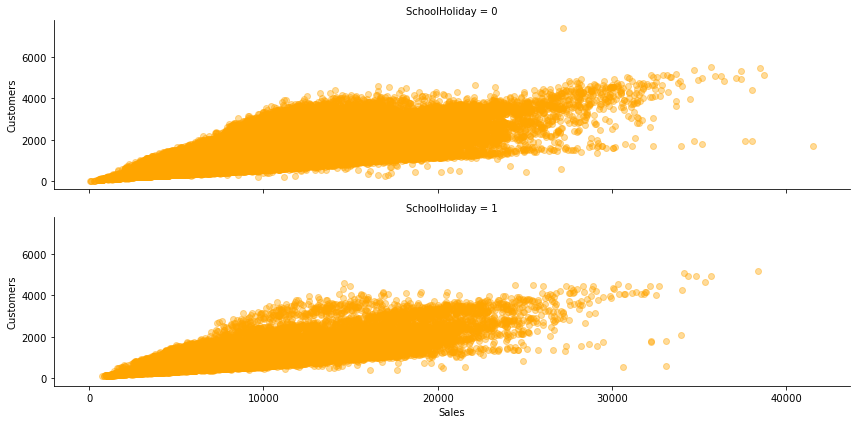

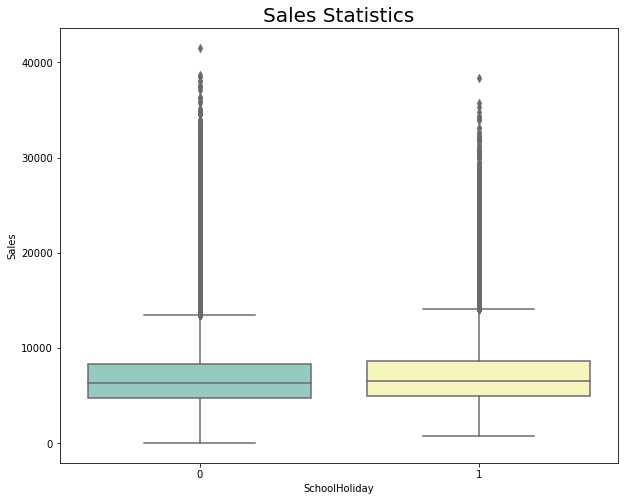

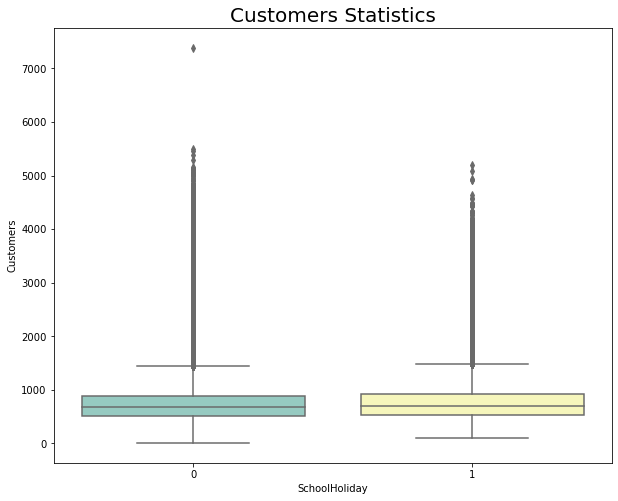

In [26]:
g=sns.FacetGrid(row='SchoolHoliday',data=train,height=3,aspect=4)
g.map(plt.scatter,'Sales','Customers',color='orange',alpha=0.4)
plt.show()

plt.figure(figsize=(10,8))
sns.boxplot(y='Sales',x='SchoolHoliday',data=train,palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()

plt.figure(figsize=(10,8))
sns.boxplot(y='Customers',x='SchoolHoliday',data=train,palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

From figures above, we can see that SchoolHoliday won't have huge effect on sales and number of customers.

## 3. Feature Engineering

In [27]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1097,2,2013-01-01,5961,1405,0,a,1
1,85,2,2013-01-01,4220,619,0,a,1
2,259,2,2013-01-01,6851,1444,0,a,1
3,262,2,2013-01-01,17267,2875,0,a,1
4,274,2,2013-01-01,3102,729,0,a,1


### 3.1. Average sales and average customers on different days and promo. (Set DayOfWeek and Promo as groups)

In [28]:
train['SalesPerCustomer']=train['Sales']/train['Customers']
train['SalesPerCustomer']

Table_1=pd.pivot_table(data=train,index=['DayOfWeek','Promo'],values=['Sales','Customers','SalesPerCustomer'],aggfunc='mean').round(0)
Table_1.rename(columns=lambda x : 'Avg_' + x, inplace=True)

# Visualization
Table_1.iplot(kind='bar',y=['Avg_Sales','Avg_Customers'],title='Average Sales and Average Customers',xTitle='(DayOfWeek,Promo)')
Table_1.iplot(y='Avg_SalesPerCustomer',title='Average Sales per Customers',xTitle='(DayOfWeek,Promo)')

Table_1

Avg_Customers  Avg_Sales  Avg_SalesPerCustomer
DayOfWeek Promo                                                
1         0              743.0     6223.0                   9.0
          1              943.0     9773.0                  11.0
2         0              688.0     5716.0                   9.0
          1              841.0     8278.0                  10.0
3         0              673.0     5618.0                   9.0
          1              799.0     7686.0                  10.0
4         0              689.0     5751.0                   9.0
          1              810.0     7599.0                  10.0
5         0              735.0     6344.0                   9.0
          1              825.0     7744.0                  10.0
6         0              660.0     5875.0                   9.0
7         0             1442.0     8225.0                   6.0

From figures above, we can see that there is no promo in the weekend. We can also see that, in the weekday, promo can stimulate people to buy more. Besides that, we can see that people tends to buy more on weekdays with promo

### 3.2.  Average sales, average number of customers and average sales per customer based on State Holidays and whether the promo is running on that day.

In [29]:
Table_2=pd.pivot_table(data=train,index=['Promo','StateHoliday'],values=['Sales','Customers','SalesPerCustomer'],aggfunc='mean').round(0)
Table_2.rename(columns=lambda x : 'Avg_' + x, inplace=True)

# Visualization
Table_2.iplot(kind='bar',y=['Avg_Sales','Avg_Customers'],title='Average Sales and Average Customers',xTitle='(Promo,StateHoliday)')
Table_2.iplot(y='Avg_SalesPerCustomer',title='Average Sales per Customers',xTitle='(Promo,StateHoliday)')

Table_2

Avg_Customers  Avg_Sales  Avg_SalesPerCustomer
Promo StateHoliday                                                
0     0                     696.0     5927.0                   9.0
      a                    1411.0     8127.0                   6.0
      b                    1380.0     7947.0                   7.0
      c                    1569.0     9744.0                   6.0
1     0                     844.0     8227.0                  10.0
      a                    1174.0     8775.0                   8.0
      b                    2270.0    13575.0                   6.0

We cann see that the sale rate in Easter Holiday and Christmas is much higher than other holidays

### 3.3 Quality check for store dataset and corresponding feature engineering (With both SQL and DFL language)

In [49]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   object 
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(1), object(4)
memory usage: 87.2+ KB


We can see that there are lots of null value in 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear' and 'PromoInterval'

In [50]:
store['Promo2']=store['Promo2'].astype(object)

for i in store.columns[store.dtypes=='object']:
    print(i,':',store[i].unique(),'\n')

StoreType : ['c' 'a' 'd' 'b'] 

Assortment : ['a' 'c' 'b'] 

Promo2 : [0 1] 

PromoInterval : [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec'] 



In [51]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 3.3.1 Create new table called avg_store 

In [52]:
query = """
    select store, avg(sales) as Avg_sales,
           avg(Customers) as Avg_Customers,
           avg(SalesPerCustomer) as Avg_SalesPerCustomer,
           max(Customers) as Max_Customers,
           min(Customers) as Min_Customers
    from train
    group by store
"""
avg_store = ps.sqldf(query, locals())

In [53]:
avg_store.head()

,Store,Avg_sales,Avg_Customers,Avg_SalesPerCustomer,Max_Customers,Min_Customers
0,1,4759.096031,564.049936,8.393038,1130,298
1,2,4953.900510,583.998724,8.408443,1164,230
2,3,6942.568678,750.077022,9.117599,1579,381
3,4,9638.401786,1321.752551,7.249827,2216,856
4,5,4676.274711,537.340180,8.611229,1081,180


In [54]:
# Adding column Std_Customers(containing Standard Deviation value of customers) to avg_store Dataframe 
Std_customer=train.groupby('Store')['Customers'].std()
avg_store=pd.merge(avg_store,Std_customer,how='inner',on='Store')
avg_store.rename(columns={'Customers':'Std_Customers'},inplace=True)

# Adding column Med_Customers(containing Median value of customers) to avg_store Dataframe 
Med_customer=train.groupby('Store')['Customers'].median()
avg_store=pd.merge(avg_store,Med_customer,how='inner',on='Store')
avg_store.rename(columns={'Customers':'Med_Customers'},inplace=True)

avg_store.head()

,Store,Avg_sales,Avg_Customers,Avg_SalesPerCustomer,Max_Customers,Min_Customers,Std_Customers,Med_Customers
0,1,4759.096031,564.049936,8.393038,1130,298,93.707476,550.0
1,2,4953.900510,583.998724,8.408443,1164,230,155.374483,575.5
2,3,6942.568678,750.077022,9.117599,1579,381,170.280290,744.0
3,4,9638.401786,1321.752551,7.249827,2216,856,198.347844,1301.5
4,5,4676.274711,537.340180,8.611229,1081,180,165.604598,564.0


### 3.3.2 Inner join the avg_store with store table

In [55]:
query = """
    select a.*, StoreType, Assortment,CompetitionDistance,
           CompetitionOpenSinceMonth,CompetitionOpenSinceYear,
           Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
    from avg_store as a
    join store as s
    on a.store = s.store
"""

store = ps.sqldf(query, locals())
store.head()

,Store,Avg_sales,Avg_Customers,Avg_SalesPerCustomer,Max_Customers,Min_Customers,Std_Customers,Med_Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4759.096031,564.049936,8.393038,1130,298,93.707476,550.0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,None
1,2,4953.900510,583.998724,8.408443,1164,230,155.374483,575.5,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,6942.568678,750.077022,9.117599,1579,381,170.280290,744.0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,9638.401786,1321.752551,7.249827,2216,856,198.347844,1301.5,c,c,620.0,9.0,2009.0,0,NaN,NaN,None
4,5,4676.274711,537.340180,8.611229,1081,180,165.604598,564.0,a,a,29910.0,4.0,2015.0,0,NaN,NaN,None


### 3.3.3 Final Data cleaning and quality check before analysis

In [69]:
# Replace missing value with 0
index=store[store['CompetitionDistance'].isnull()].index
store.loc[index,'CompetitionDistance']=0

index=store[(store['CompetitionOpenSinceMonth'].isnull())&(store['CompetitionOpenSinceYear'].isnull())].index
store.loc[index,['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']]=0

index=store[(store['Promo2SinceWeek'].isnull())&(store['Promo2SinceYear'].isnull())&(store['Promo2']==0)].index
store.loc[index,['Promo2SinceWeek','Promo2SinceYear']]=0

In [70]:
store[['CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear',
       'Promo2SinceWeek',
       'Promo2SinceYear']]=store[['CompetitionOpenSinceMonth',
                                  'CompetitionOpenSinceYear',
                                  'Promo2SinceWeek',
                                  'Promo2SinceYear']].astype(int)

store[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear']].dtypes

CompetitionOpenSinceMonth    int32
CompetitionOpenSinceYear     int32
Promo2SinceWeek              int32
Promo2SinceYear              int32
dtype: object

In [71]:
# Setting Promo Interval equal to zero for those who are not continuing Promo and for missing values
index=store[(store['Promo2']==0)&(store['PromoInterval'].isnull().any())].index
store.loc[index,'PromoInterval']=0

store['PromoInterval'].isnull().any() # To check

False

In [72]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   Avg_sales                  1115 non-null   float64
 2   Avg_Customers              1115 non-null   float64
 3   Avg_SalesPerCustomer       1115 non-null   float64
 4   Max_Customers              1115 non-null   int64  
 5   Min_Customers              1115 non-null   int64  
 6   Std_Customers              1115 non-null   float64
 7   Med_Customers              1115 non-null   float64
 8   StoreType                  1115 non-null   object 
 9   Assortment                 1115 non-null   object 
 10  CompetitionDistance        1115 non-null   float64
 11  CompetitionOpenSinceMonth  1115 non-null   int32  
 12  CompetitionOpenSinceYear   1115 non-null   int32  
 13  Promo2                     1115 non-null   int64

### 3.3.4 How competitionn Distance affect sales data

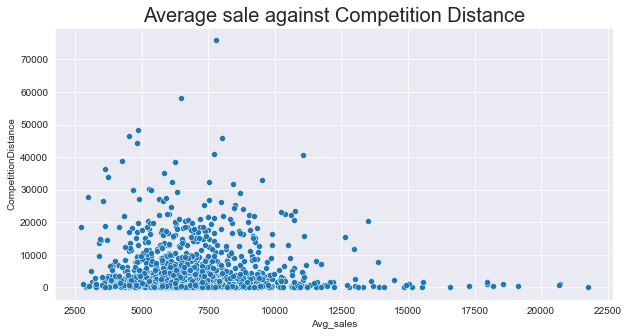

C:\Users\yanli\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



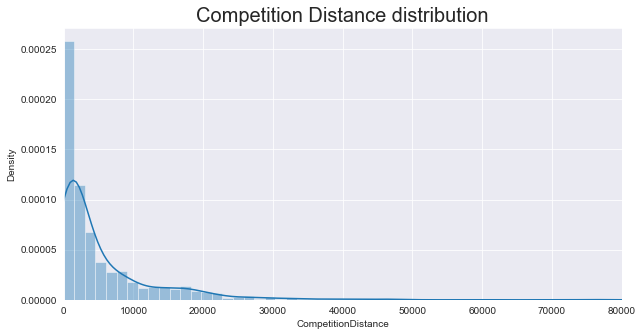

In [74]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.scatterplot(x='Avg_sales',y='CompetitionDistance',data=store)
plt.title('Average sale against Competition Distance',fontdict={'fontsize':20})
plt.show()

plt.figure(figsize=(10,5))
sns.distplot(store['CompetitionDistance'])
plt.title('Competition Distance distribution',fontdict={'fontsize':20})
plt.xlim(0,80000)
plt.show()

We can see that the Rossman Store has lots of close competitors nearby. But it still has good sales data.

### 3.3.5 How Promo Interval affect avg_sales

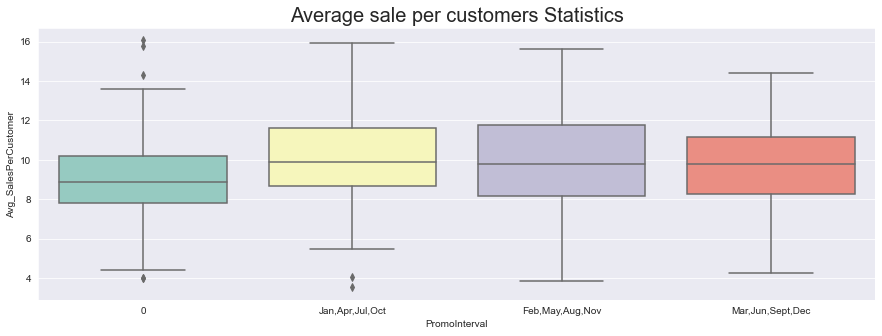

In [75]:
plt.figure(figsize=(15,5))
sns.boxplot(x='PromoInterval',y='Avg_SalesPerCustomer',data=store,palette='Set3')
plt.title('Average sale per customers Statistics', fontdict={'fontsize':20})
plt.show()

There is no big affect based on promo interval

### 3.3.6 How store type affect sales rate

<Figure size 1080x576 with 0 Axes>

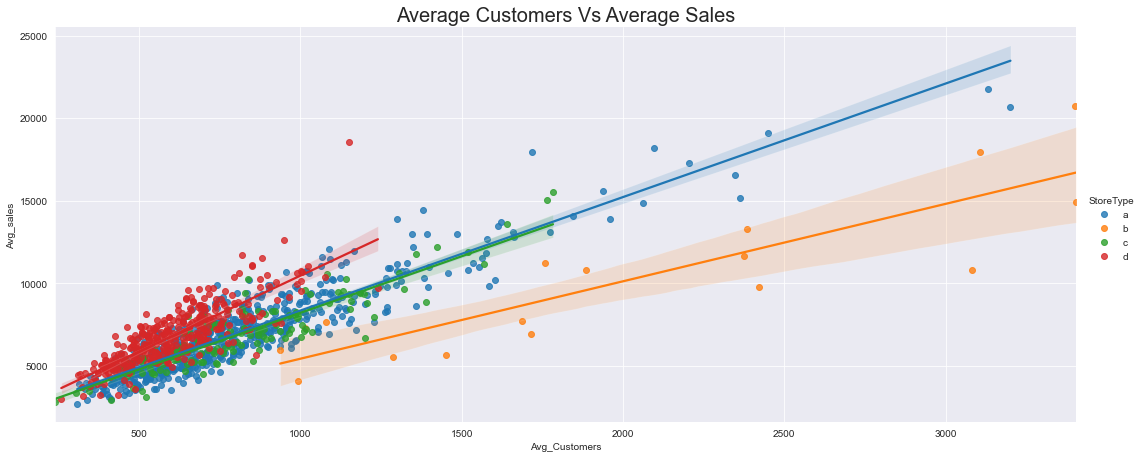

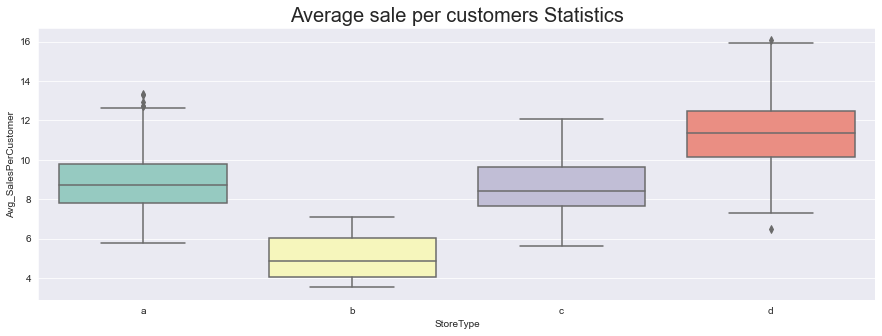

In [81]:
# scatter plot - Average Customers against Average Sales
plt.figure(figsize=(15,8))
sns.lmplot(x='Avg_Customers',y='Avg_sales',hue='StoreType',data=store,hue_order=['a','b','c','d'],height=6,aspect=2.5)
plt.title('Average Customers Vs Average Sales', fontdict={'fontsize':20})
plt.show()

# boxplot - Average sale per customers 
plt.figure(figsize=(15,5))
sns.boxplot(x='StoreType',y='Avg_SalesPerCustomer',data=store,order=['a','b','c','d'],palette='Set3')
plt.title('Average sale per customers Statistics', fontdict={'fontsize':20})
plt.show()

It is quite interesting to observe that the line of assortment type a and c are almost parallel, ie. both are having the same average number of customers but the sales are higher in type c. Also the sales rate is highest in type c.

## 4. Sales Prediction with Random Forest Regressor

### 4.1 Create dataset for RFR

In [90]:
new_train=pd.merge(train,store,how='left',on='Store')
new_train['Year']=new_train['Date'].dt.year
new_train['Month']=new_train['Date'].dt.month
new_train['Day']=new_train['Date'].dt.day
new_train['Week']=new_train['Date'].dt.week

new_train['MonthCompetitionOpen']=12*(new_train['Year']-new_train['CompetitionOpenSinceYear'])+\
new_train['Month']-new_train['CompetitionOpenSinceMonth']
new_train.loc[(new_train['CompetitionOpenSinceYear']==0),'MonthCompetitionOpen']=0

new_train['WeekPromoOpen']=52.14298*(new_train['Year']-new_train['Promo2SinceYear'])+\
new_train['Week']-new_train['Promo2SinceWeek']
new_train.loc[(new_train['Promo2SinceYear']==0),'WeekPromoOpen']=0
new_train.info()

<ipython-input-90-c006389c0348>:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Promo                      844338 non-null  int64         
 6   StateHoliday               844338 non-null  object        
 7   SchoolHoliday              844338 non-null  int64         
 8   SalesPerCustomer           844338 non-null  float64       
 9   Avg_sales                  844338 non-null  float64       
 10  Avg_Customers              844338 non-null  float64       
 11  Avg_SalesPerCustomer       844338 non-null  float64 

In [91]:
new_train['Promo2']=new_train['Promo2'].astype(int)
new_train.drop('Customers',axis=1,inplace=True)

In [92]:
trainS=new_train[['Store', 'DayOfWeek','Sales','Promo',
       'StateHoliday', 'SchoolHoliday','StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval','Avg_Customers',
       'Max_Customers', 'Min_Customers',
       'Std_Customers', 'Med_Customers', 'Year', 'Month', 'Day', 'Week',
       'MonthCompetitionOpen', 'WeekPromoOpen']]
trainS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Sales                      844338 non-null  int64  
 3   Promo                      844338 non-null  int64  
 4   StateHoliday               844338 non-null  object 
 5   SchoolHoliday              844338 non-null  int64  
 6   StoreType                  844338 non-null  object 
 7   Assortment                 844338 non-null  object 
 8   CompetitionDistance        844338 non-null  float64
 9   CompetitionOpenSinceMonth  844338 non-null  int32  
 10  CompetitionOpenSinceYear   844338 non-null  int32  
 11  Promo2                     844338 non-null  int32  
 12  Promo2SinceWeek            844338 non-null  int32  
 13  Promo2SinceYear            84

### 4.2 Normalizing selected features

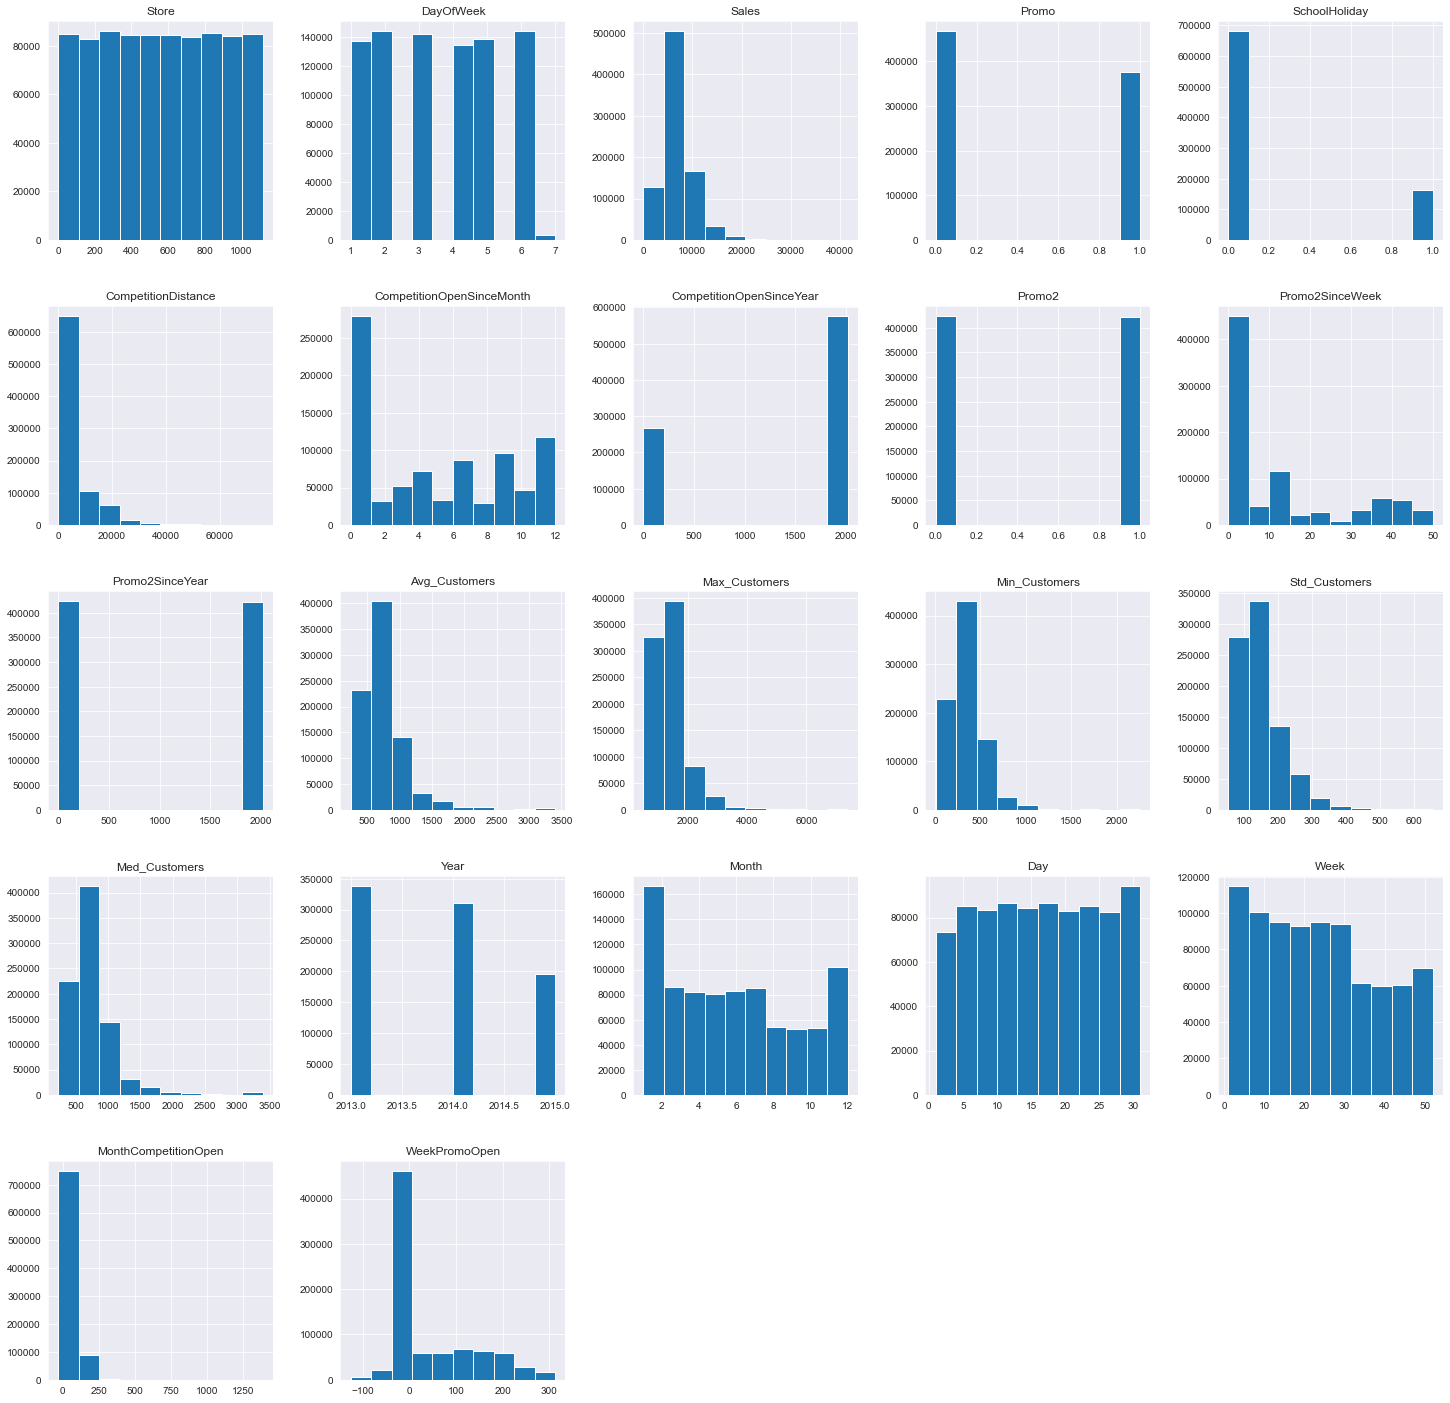

In [96]:
# Visualization to chech whether the data is distributed normally
trainS.hist(figsize=(25,25))
plt.show()

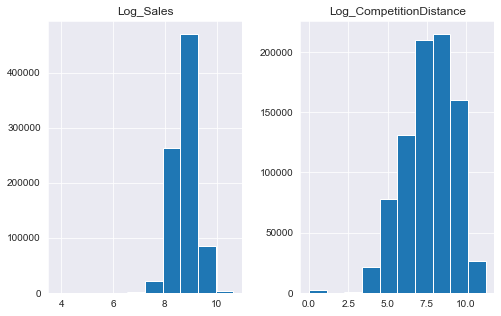

In [99]:
trainS['Log_Sales']=np.log(trainS['Sales'])

index=trainS[trainS['CompetitionDistance']==0].index
trainS['CompetitionDistance'][index]=1
trainS['Log_CompetitionDistance']=np.log(trainS['CompetitionDistance'])

trainS[['Log_Sales','Log_CompetitionDistance',]].hist(figsize=(8,5))
plt.show()

trainS.drop(['Sales','CompetitionDistance'],axis=1,inplace=True)

In [100]:
final_train=pd.get_dummies(data=trainS,columns=['StoreType','StateHoliday','Assortment','PromoInterval'])

### 4.3 Feed data to RFR

In [107]:
X=final_train.drop('Log_Sales',axis=1)
y=final_train['Log_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101) 

rfr=RandomForestRegressor(n_estimators=200,
                          criterion='friedman_mse',
                          max_features='sqrt',
                          oob_score=True,
                          n_jobs=32,
                          verbose=1,
                          random_state=101)

rfr.fit(X_train,y_train)

predict=rfr.predict(X_test)
predict

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:  1.6min
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:  2.0min finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   24.9s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:   27.9s finished


array([8.61480632, 9.41728858, 9.17856983, ..., 8.5095164 , 8.57966083,
       8.97415238])

### 4.3.1 Model Evaluationn

In [110]:
print(f'oob score is {rfr.oob_score_}')

mse=mean_squared_error(np.exp(y_test),np.exp(predict))
print(f'Root Mean Square Error is {sqrt(mse)}')

oob score is 0.923076613851415
Root Mean Square Error is 853.6631848086204


RMSE and OBB score is ok

In [111]:
prediction=pd.DataFrame(np.exp(y_test))
prediction['Sales_prediction']=np.exp(predict).round()
prediction.rename(columns={'Log_Sales':'Sales'},inplace=True)

prediction.reset_index(inplace=True)
prediction.drop('index',axis=1,inplace=True)
prediction

,Sales,Sales_prediction
0,4880.0,5513.0
1,11791.0,12299.0
2,10209.0,9687.0
3,4915.0,4953.0
4,6457.0,7618.0
...,...,...
126646,7222.0,6675.0
126647,10666.0,8720.0
126648,5990.0,4962.0
126649,6884.0,5322.0


# Reference

#### 1. https://www.kaggle.com/code/prashantlal/rossman-store-sale-prediction-using-random-forest/notebook